# BajaNestVision

## Installation

### Pytorch installation with conda

In [1]:
#conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia

In [2]:
import torch
torch.__version__

'1.12.1+cu116'

### installing detectron2

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-fehuf30u
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-fehuf30u
  Resolved https://github.com/facebookresearch/detectron2.git to commit 3ff5dd1cff4417af07097064813c9f28d7461d3c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.1/435.1 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 37.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.

## Import libraries

In [1]:
from detectron2.utils.logger import setup_logger
logger = setup_logger()
from detectron2.data.datasets import register_coco_instances

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import CfgNode as CN

from tqdm import tqdm
import os
import torch
from torch.utils.data import Dataset, DataLoader
from detectron2.config import get_cfg
from detectron2 import model_zoo
import pickle
import matplotlib.pyplot as plt
import random
import cv2

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

## Create Train, Validation and Test dataset

In [3]:
from dataset_utils import train_val_test_split

In [7]:
json_file_path = 'Nest_composition_labels.json'
output_dir = 'dataset'
img_path = 'output_crops'

train_val_test_split(json_file_path, output_dir, img_path)

## Register datasets

In [4]:
# Some configurations
name_ds = "dataset"
name_ds_train = name_ds + "_train"
name_ds_val = name_ds + "_val"
name_ds_test = name_ds + "_test"
image_root_train = name_ds + "/train"
image_root_validation = name_ds + "/validation"
image_root_test = name_ds + "/test"

json_file_train = name_ds + "/train/" + 'coco_annotation_train.json'
json_file_val = name_ds + "/validation/" + 'coco_annotation_validation.json'
json_file_test = name_ds + "/test/" + 'coco_annotation_test.json'

# Register datasets
## train dataset
register_coco_instances(
    name = name_ds_train,
    metadata = {},
    json_file = json_file_train,
    image_root = image_root_train
    )

## validation dataset
register_coco_instances(
    name = name_ds_val,
    metadata = {},
    json_file = json_file_val,
    image_root = image_root_validation
    )

## test dataset
register_coco_instances(
    name = name_ds_test,
    metadata = {},
    json_file = json_file_test,
    image_root = image_root_test
    )


In [5]:
train_metadata = MetadataCatalog.get(name_ds_train)
train_dataset_dicts = DatasetCatalog.get(name_ds_train)

[02/09 22:30:18 d2.data.datasets.coco]: Loaded 128 images in COCO format from dataset/train/coco_annotation_train.json


In [6]:
val_metadata = MetadataCatalog.get(name_ds_val)
val_dataset_dicts = DatasetCatalog.get(name_ds_val)

[02/09 22:30:20 d2.data.datasets.coco]: Loaded 16 images in COCO format from dataset/validation/coco_annotation_validation.json


In [7]:
test_metadata = MetadataCatalog.get(name_ds_test)
test_dataset_dicts = DatasetCatalog.get(name_ds_test)

[02/09 22:30:20 d2.data.datasets.coco]: Loaded 16 images in COCO format from dataset/test/coco_annotation_test.json


## Visualize samples

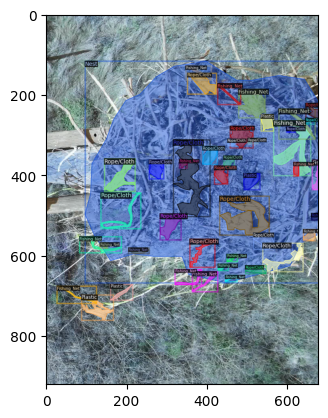

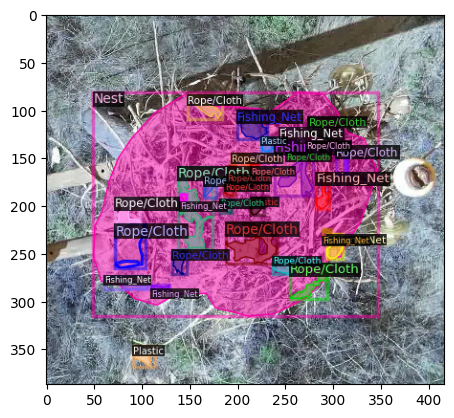

In [7]:
for d in random.sample(train_dataset_dicts,2):
    img = cv2.imread(d['file_name'])
    visualizer = Visualizer(img[:,:,::-1], metadata= train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:,:,::-1])
    plt.show()

## Setting anchor sizes and anchor ratios

In [8]:
output_dir = "output/Pre-train"
os.makedirs(output_dir, exist_ok=True)
output_cfg_path = os.path.join(output_dir, "cfg.pickle")
nc = 4
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
from detectron2.projects import point_rend
# Select a lighter model to train faster
config_file = "detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml"
checkpoint_file = "detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_edd263.pkl"

In [11]:
from dataset_utils import find_min_max_dimensions

In [14]:
folder_path = "dataset/train"
min_w, min_h, max_w, max_h = find_min_max_dimensions(folder_path)

print(f"Ancho mínimo de las imágenes: {min_w}")
print(f"Alto mínimo de las imágenes: {min_h}")
print(f"Ancho máximo de las imágenes: {max_w}")
print(f"Alto máximo de las imágenes: {max_h}")

Ancho mínimo de las imágenes: 516
Alto mínimo de las imágenes: 513
Ancho máximo de las imágenes: 2174
Alto máximo de las imágenes: 1919


In [15]:
folder_path = "dataset/validation/"
min_w, min_h, max_w, max_h = find_min_max_dimensions(folder_path)

print(f"Ancho mínimo de las imágenes: {min_w}")
print(f"Alto mínimo de las imágenes: {min_h}")
print(f"Ancho máximo de las imágenes: {max_w}")
print(f"Alto máximo de las imágenes: {max_h}")

Ancho mínimo de las imágenes: 585
Alto mínimo de las imágenes: 641
Ancho máximo de las imágenes: 2192
Alto máximo de las imágenes: 1700


In [16]:
cfg = get_cfg()

point_rend.add_pointrend_config(cfg)
cfg.merge_from_file(config_file)

cfg.MODEL.WEIGHTS = checkpoint_file

cfg.INPUT.MIN_SIZE_TRAIN = (513, 516)  # Increase the minimum size for training images.
cfg.INPUT.MAX_SIZE_TRAIN = 1700 # Increase the maximum size for training images.
cfg.INPUT.MIN_SIZE_TEST = (641,585)            # Increase the minimum size for testing/inference images.
cfg.INPUT.MAX_SIZE_TEST = 1700       

cfg.DATASETS.TRAIN = (name_ds_train,)

cfg.DATALOADER.NUM_WORKERS = 2
# Images per batch
cfg.SOLVER.IMS_PER_BATCH = 6
# Learning rate
cfg.SOLVER.BASE_LR = 0.001
# Iterations
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.CHECKPOINT_PERIOD = 500
# Evaluation
cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD
# Classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc
cfg.MODEL.DEVICE = device
cfg.OUTPUT_DIR = output_dir

cfg.MODEL.POINT_HEAD.NUM_CLASSES = nc

In [17]:
trainer = DefaultTrainer(cfg)

[02/09 04:42:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [18]:
print("MIN_SIZE_TRAIN", cfg.INPUT.MIN_SIZE_TRAIN)
print("MAX_SIZE_TRAIN", cfg.INPUT.MAX_SIZE_TRAIN)

MIN_SIZE_TRAIN (513, 516)
MAX_SIZE_TRAIN 1700


In [19]:
from hyperparameter_tuning import AnchorCalculator, anchorSizeRatioTuner

In [20]:
anchorcalcualtor = AnchorCalculator(trainer,cfg)

In [21]:
data = anchorcalcualtor.data
for i in data:
  print(i['image'].shape)

torch.Size([3, 516, 553])
torch.Size([3, 516, 561])
torch.Size([3, 513, 742])
torch.Size([3, 516, 591])
torch.Size([3, 513, 587])
torch.Size([3, 516, 643])


In [22]:
images = trainer.model.preprocess_image(data)
print(images.tensor.shape)

torch.Size([6, 3, 544, 768])


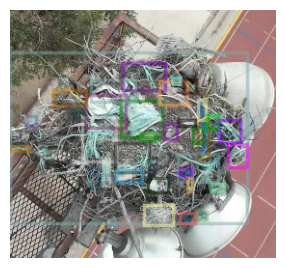

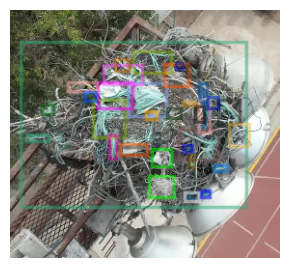

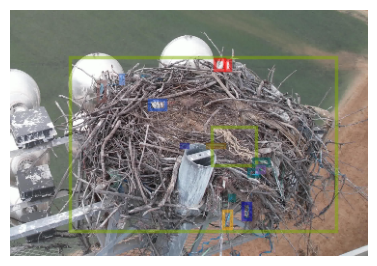

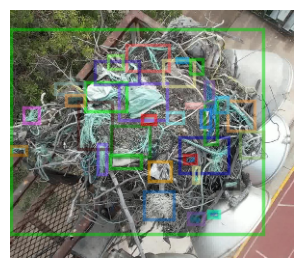

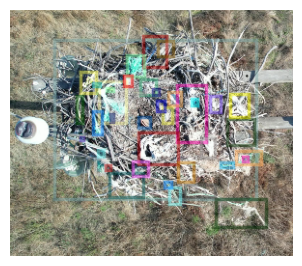

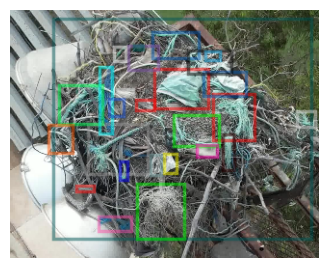

In [23]:
anchorcalcualtor.visualize_images_gt_box()

In [24]:
gt_boxes = anchorcalcualtor.get_gt_boxes(1000)
print()
print(gt_boxes.shape)

100%|██████████| 1000/1000 [00:00<00:00, 63376.26it/s]


torch.Size([185000, 4])


In [25]:
gt_wh = anchorcalcualtor.boxes2wh()
print(gt_wh.min(), gt_wh.max())

tensor(4.9592) tensor(552.5803)


In [26]:
print("sizes", cfg.MODEL.ANCHOR_GENERATOR.SIZES)
print("ratios", cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS)

sizes [[32], [64], [128], [256], [512]]
ratios [[0.5, 1.0, 2.0]]


In [27]:
print("recall", anchorcalcualtor.best_recall())
print("fitness", anchorcalcualtor.fitness())

recall tensor(0.9784)
fitness tensor(0.6712)


#### Using clustering algorithms

In [28]:
gt_sizes = anchorcalcualtor.wh2size()
gt_ratios = anchorcalcualtor.wh2ratio()

In [29]:
anchorTuner = anchorSizeRatioTuner(trainer, fit_fn = anchorcalcualtor.fitness)

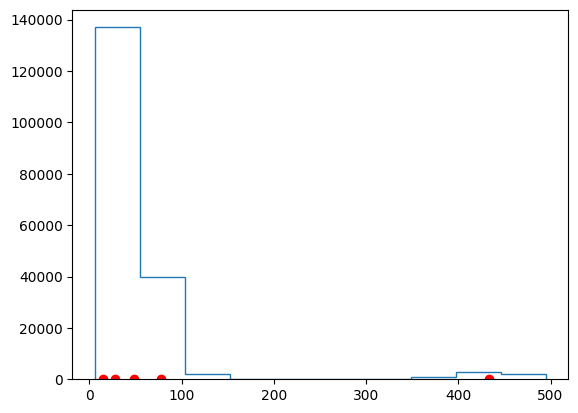

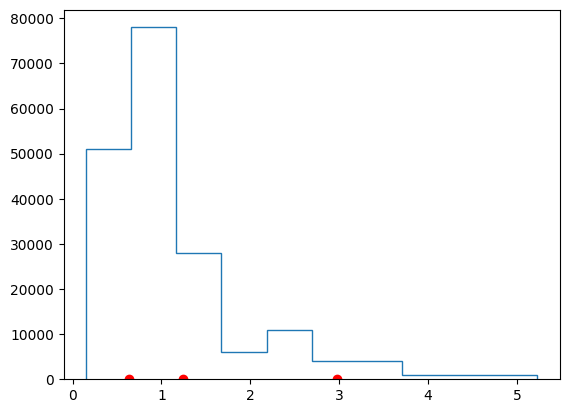

In [30]:
sizes = anchorTuner.estimate_clusters(gt_sizes, 5)
anchorTuner.visualize_clusters(gt_sizes, sizes)
ratios = anchorTuner.estimate_clusters(gt_ratios, 3)
anchorTuner.visualize_clusters(gt_ratios, ratios)

In [31]:
anchors = trainer.model.proposal_generator.anchor_generator.generate_cell_anchors
anchors = anchors(sizes, ratios)

In [32]:
anchorcalcualtor.fitness(anchors = anchors)

tensor(0.7774, dtype=torch.float64)

In [33]:
print("sizes", sizes)
print("ratios", ratios)

sizes [ 48.46438   27.397375  14.928964  77.593185 433.6012  ]
ratios [0.6311961 2.9770253 1.2415253]


#### Evolve the results using the genetic algorithm

In [34]:
e_sizes, e_ratios = anchorTuner.evolve(sizes, ratios)

Evolving ratios and sizes, Fitness = 0.7896: 100%|██████████| 10000/10000 [19:56<00:00,  8.36it/s]


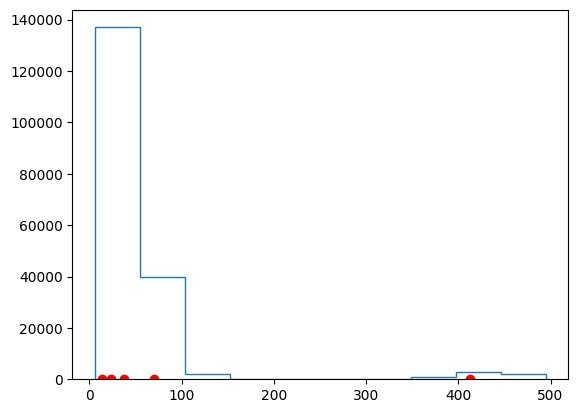

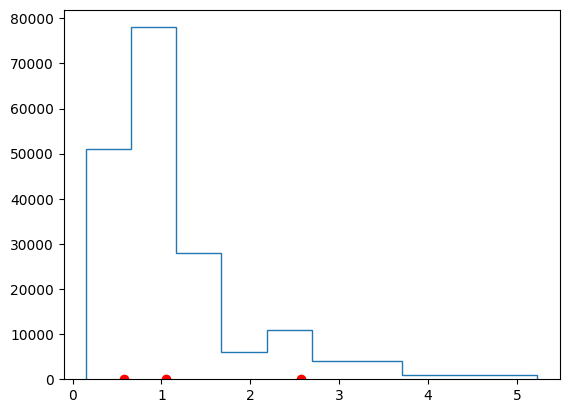

In [35]:
anchorTuner.visualize_clusters(gt_sizes, e_sizes)
anchorTuner.visualize_clusters(gt_ratios, e_ratios)

In [36]:
print("sizes", e_sizes)
print("ratios", e_ratios)

sizes [ 37.53017704  23.97593805  13.58284054  69.7716983  412.61241511]
ratios [0.58218389 2.56953604 1.05380876]


## Pixel means and Standar deviations

### Installing and loading libraries

In [38]:
#!pip install albumentations

In [39]:
from dataset_utils import DatasetWithTransform
from hyperparameter_tuning import ImagesMeanStd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json

### Batch transform dataset

In [40]:
batch_size = 32
num_workers = 2

In [41]:
image_size = 640
augs = A.Compose([
    A.Resize(height = image_size, width = image_size),
    ToTensorV2()])

In [42]:
with open(json_file_train) as f:
  ds = json.load(f)['images']

tds = DatasetWithTransform(ds, img_dir=image_root_train, transform=augs)
image_loader = DataLoader(tds, 
                          batch_size  = batch_size, 
                          shuffle     = False, 
                          num_workers = num_workers,
                          pin_memory  = True)

### Obtain pixels mean and std

In [43]:
ims = ImagesMeanStd()

for inputs in tqdm(image_loader):
    ims.push(inputs)

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


In [44]:
print(ims.mean)
print(ims.std)

tensor([120.9248, 128.0390, 128.2648])
tensor([53.7788, 54.1133, 54.4960])


## Training configuration

In [8]:
output_dir = "output/pointrend_4_cls_6_nest"
os.makedirs(output_dir, exist_ok=True)
output_cfg_path = os.path.join(output_dir, "cfg.pickle")
nc = 4
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
from detectron2.projects import point_rend
# Select a lighter model to train faster
config_file = "detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml"
checkpoint_file = "detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_edd263.pkl"

### cfg file

In [10]:
cfg = get_cfg()

point_rend.add_pointrend_config(cfg)
cfg.merge_from_file(config_file)

cfg.MODEL.WEIGHTS = checkpoint_file

cfg.INPUT.MIN_SIZE_TRAIN = 513  # Increase the minimum size for training images.
cfg.INPUT.MAX_SIZE_TRAIN = 2000 # Increase the maximum size for training images.
cfg.INPUT.MIN_SIZE_TEST = 585 # Increase the minimum size for testing/inference images.
cfg.INPUT.MAX_SIZE_TEST = 2000  


cfg.DATASETS.TRAIN = (name_ds_train,)
cfg.DATASETS.TEST = (name_ds_val,)

cfg.DATALOADER.NUM_WORKERS = 4

cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.005
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.STEPS = (4000, 6000)
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.NESTROV = False
cfg.SOLVER.MAX_ITER = 8000

cfg.SOLVER.CHECKPOINT_PERIOD = 500

cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[37.53017704], [23.97593805], [13.58284054], [69.7716983], [412.61241511]]    
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.58218389, 2.56953604, 1.05380876]] 

cfg.MODEL.PIXEL_MEAN = [120.9248, 128.0390, 128.2648] 
cfg.MODEL.PIXEL_STD = [53.7788, 54.1133, 54.4960]

cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD

cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc
cfg.MODEL.DEVICE = device
cfg.OUTPUT_DIR = output_dir

cfg.MODEL.POINT_HEAD.NUM_CLASSES = nc

In [11]:
# save configuration file for future use
with open(output_cfg_path, "wb") as f:
  pickle.dump(cfg, f, protocol = pickle.HIGHEST_PROTOCOL)

## Training

In [12]:
import gc
gc.collect()

138

In [13]:
from model import *

In [14]:
trainer = EagleNestAugTrainer(cfg)

bm_hook = BestModelHook(cfg, metric  = "segm/AP50", min_max = "max")
trainer.register_hooks(hooks=[bm_hook])

[02/09 22:31:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [15]:
import torch
from detectron2.layers import cat
from detectron2.structures import Boxes
from detectron2.projects.point_rend.point_features import(
    get_point_coords_wrt_image,
    sample_point_labels,
    get_uncertain_point_coords_with_randomness
)
from detectron2.projects.point_rend.mask_head import (
    calculate_uncertainty
)

In [16]:
def _sample_train_points(self, coarse_mask, instances):
    assert self.training
    gt_classes = cat([x.gt_classes for x in instances])
    with torch.no_grad():
        # Step 1: sample point coordinates (point_coords)
        point_coords=get_uncertain_point_coords_with_randomness(coarse_mask, 
                                                                lambda logits: calculate_uncertainty(logits, gt_classes),
                                                                self.mask_point_train_num_points,
                                                                self.mask_point_oversample_ratio,
                                                                self.mask_point_importance_sample_ratio,)
        # Step 2: get point_coords with respect to the image
        proposal_boxes = [x.proposal_boxes for x in instances]
        cat_boxes = Boxes.cat(proposal_boxes)
        point_coords_wrt_image = get_point_coords_wrt_image(cat_boxes.tensor, point_coords)
        # Step 3: generate labels for the sampled points
        sR, sP, s2 = point_coords.shape
        assert s2 == 2, point_coords.shape
        point_labels = torch.zeros(size = (sR, sP), 
                                   dtype  = point_coords.dtype, 
                                   layout = point_coords.layout, 
                                   device = point_coords.device)
        try:
            point_labels = sample_point_labels(instances, 
                                               point_coords_wrt_image)
        except:
            print("**************empty instances**************")
    
    return point_coords, point_labels

In [17]:
import types
mask_head = trainer.model.roi_heads.mask_head
mask_head._sample_train_points = types.MethodType(
    _sample_train_points,
    mask_head
)

In [18]:
trainer.train()

[02/09 22:39:06 d2.engine.train_loop]: Starting training from iteration 0
[02/09 22:39:22 d2.utils.events]:  eta: 1:24:15  iter: 19  total_loss: 5.772  loss_cls: 2.523  loss_box_reg: 0.1472  loss_mask: 0.6373  loss_mask_point: 0.699  loss_rpn_cls: 0.6427  loss_rpn_loc: 0.6627    time: 0.6203  last_time: 0.5910  data_time: 0.1251  last_data_time: 0.0192   lr: 9.9905e-05  max_mem: 5640M
[02/09 22:39:38 d2.utils.events]:  eta: 1:24:47  iter: 39  total_loss: 2.863  loss_cls: 0.5354  loss_box_reg: 0.159  loss_mask: 0.623  loss_mask_point: 0.6864  loss_rpn_cls: 0.6187  loss_rpn_loc: 0.2227    time: 0.6455  last_time: 0.7116  data_time: 0.1009  last_data_time: 0.1354   lr: 0.0001998  max_mem: 5889M
[02/09 22:39:50 d2.utils.events]:  eta: 1:25:00  iter: 59  total_loss: 2.662  loss_cls: 0.4451  loss_box_reg: 0.1831  loss_mask: 0.567  loss_mask_point: 0.6829  loss_rpn_cls: 0.5986  loss_rpn_loc: 0.1933    time: 0.6436  last_time: 0.5536  data_time: 0.0899  last_data_time: 0.0099   lr: 0.0002997  

## Keep only best model and remove all others

In [19]:
from glob import glob
files = glob(os.path.join(cfg.OUTPUT_DIR, "*.pth"))
for f in files:
    if f != os.path.join(cfg.OUTPUT_DIR, "model_best.pth"):
        os.remove(f)

## Draw Some Samples

In [20]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST  = 0.65
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 
                                 "model_best.pth")
predictor = DefaultPredictor(cfg)

[02/10 00:13:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/pointrend_4_cls_6_nest/model_best.pth ...


In [21]:
from viz_prediction import plot_random_samples

[02/10 00:13:53 d2.data.datasets.coco]: Loaded 16 images in COCO format from dataset/validation/coco_annotation_validation.json


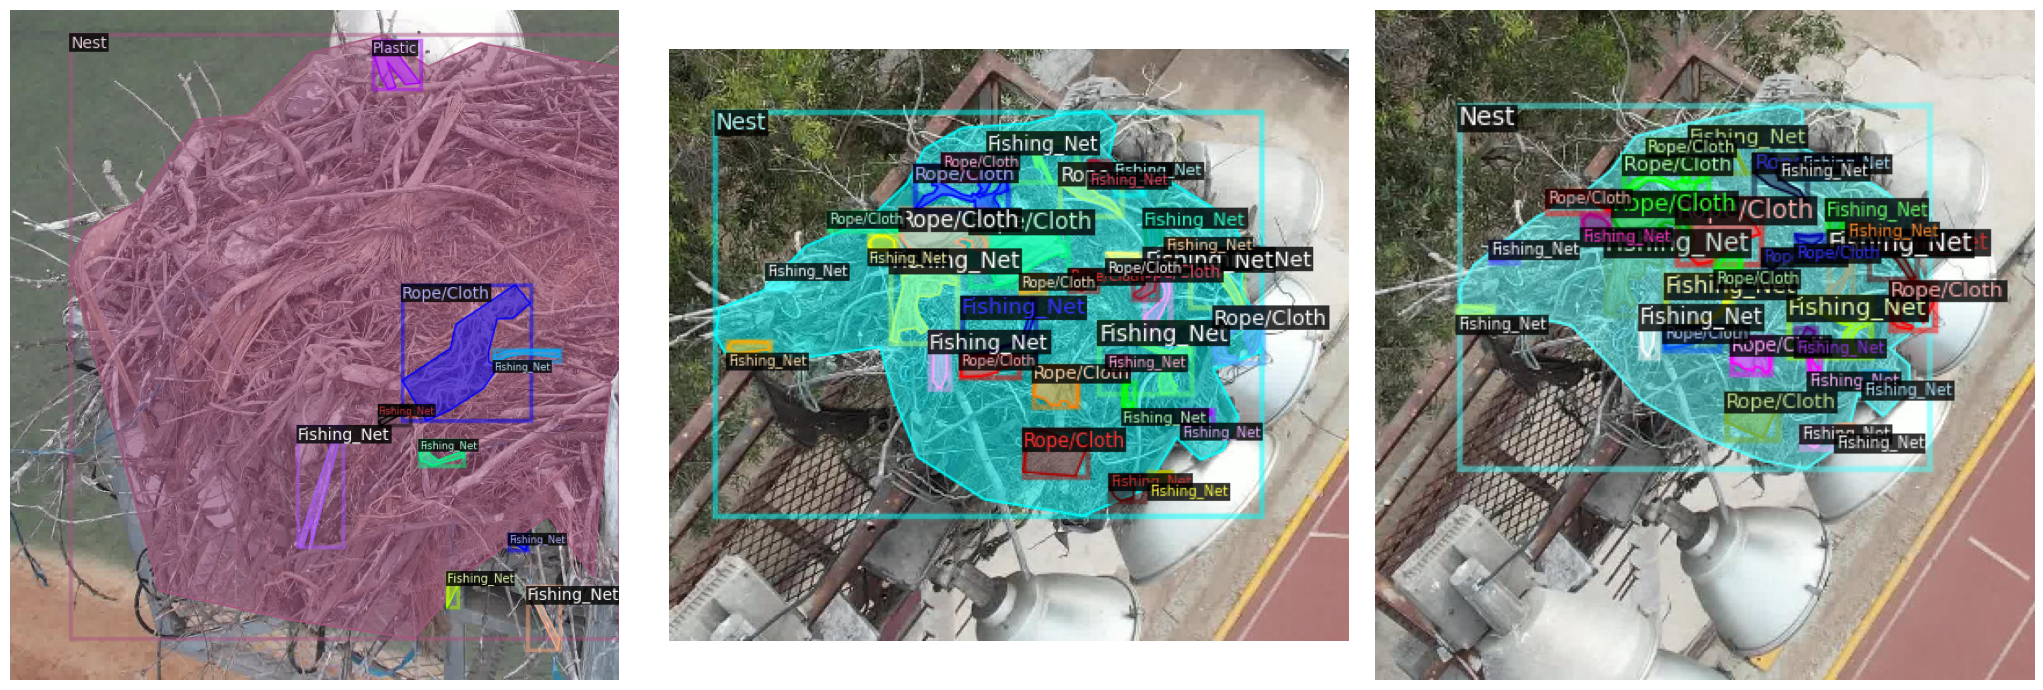

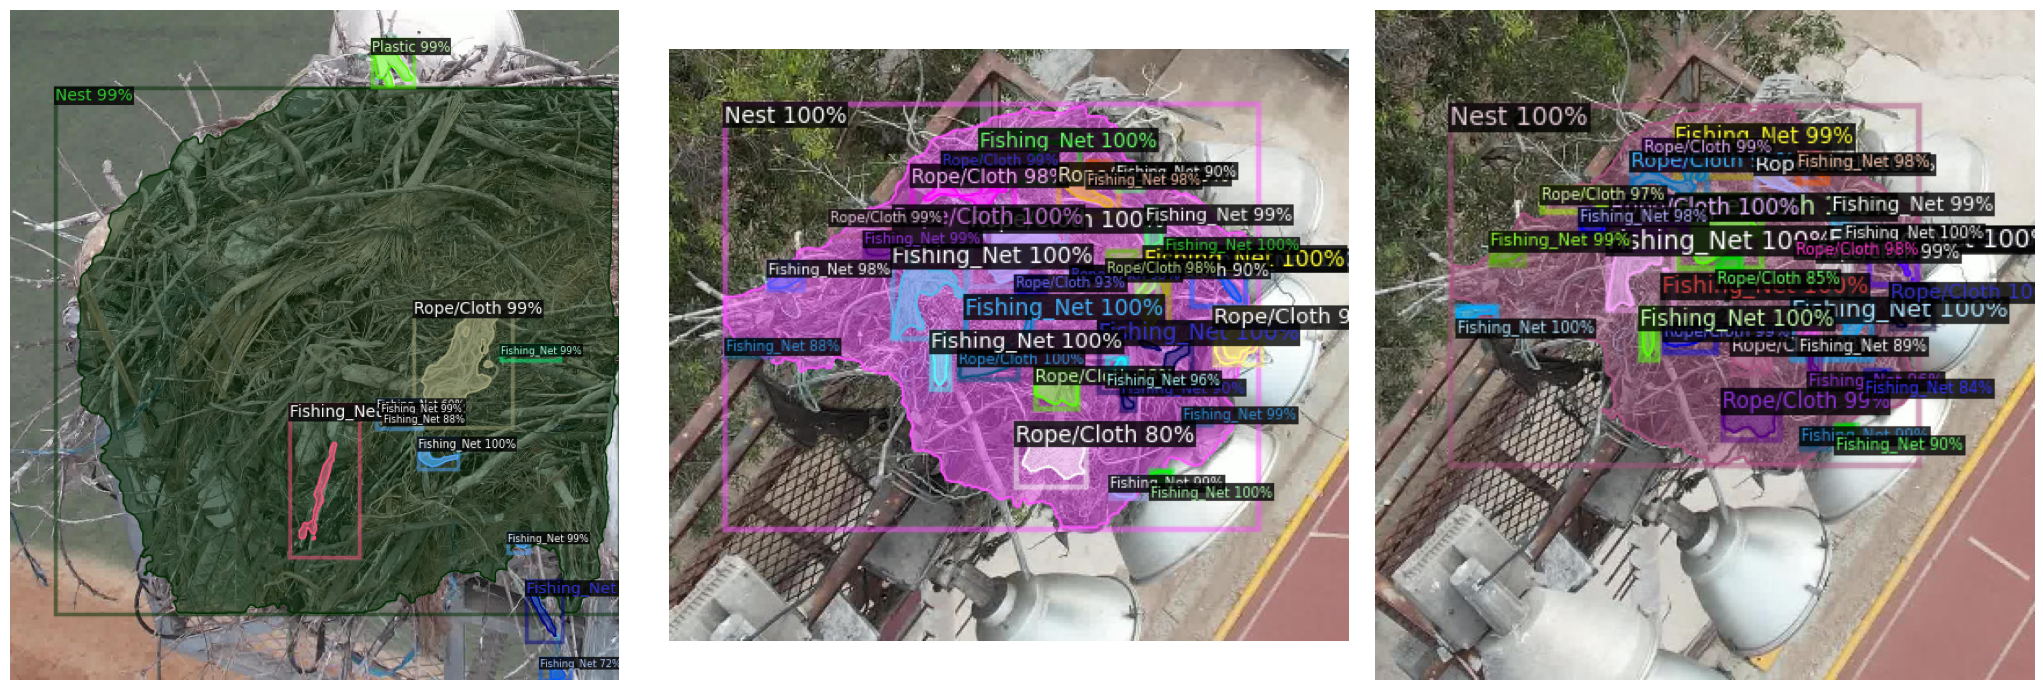

In [22]:
plot_random_samples(name_ds_val, predictor = predictor)

In [23]:
!zip -r pointrend_4_cls_7k.zip output/pointrend_4_cls_6_nest

updating: output/pointrend_4_cls_6_nest/ (stored 0%)
updating: output/pointrend_4_cls_6_nest/events.out.tfevents.1707493624.nimnpvcwxx.62.0 (deflated 72%)
updating: output/pointrend_4_cls_6_nest/cfg.pickle (deflated 50%)
updating: output/pointrend_4_cls_6_nest/metrics.json (deflated 77%)
updating: output/pointrend_4_cls_6_nest/coco_instances_results.json (deflated 59%)
updating: output/pointrend_4_cls_6_nest/model_best.pth (deflated 7%)
updating: output/pointrend_4_cls_6_nest/last_checkpoint (stored 0%)
updating: output/pointrend_4_cls_6_nest/events.out.tfevents.1707502683.nimnpvcwxx.1367.0 (deflated 72%)
  adding: output/pointrend_4_cls_6_nest/events.out.tfevents.1707518364.n6mrj6wo53.1197.0 (deflated 72%)
  adding: output/pointrend_4_cls_6_nest/events.out.tfevents.1707509526.n6mrj6wo53.62.0 (deflated 72%)


In [25]:
!zip -r dataset.zip dataset/

  adding: dataset/ (stored 0%)
  adding: dataset/train/ (stored 0%)
  adding: dataset/train/DJI_0140_frame_0185_object_0.jpg (deflated 0%)
  adding: dataset/train/DJI_0140_frame_0123_object_0.jpg (deflated 0%)
  adding: dataset/train/DJI_0230_frame_0003_object_0.jpg (deflated 0%)
  adding: dataset/train/DJI_0140_frame_0124_object_0.jpg (deflated 0%)
  adding: dataset/train/DJI_0228_frame_0042_object_0.jpg (deflated 1%)
  adding: dataset/train/DJI_0227_frame_0111_object_0.jpg (deflated 0%)
  adding: dataset/train/DJI_0227_frame_0055_object_0.jpg (deflated 0%)
  adding: dataset/train/DJI_0227_frame_0033_object_1.jpg (deflated 0%)
  adding: dataset/train/DJI_0142_frame_0056_object_0.jpg (deflated 0%)
  adding: dataset/train/DJI_0140_frame_0031_object_0.jpg (deflated 0%)
  adding: dataset/train/DJI_0227_frame_0012_object_0.jpg (deflated 0%)
  adding: dataset/train/DJI_0141_frame_0109_object_0.jpg (deflated 0%)
  adding: dataset/train/DJI_0142_frame_0049_object_0.jpg (deflated 0%)
  adding: